# Task 3 - Multi Layer Perceptron Regression

In [1]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.impute import SimpleImputer

In [2]:
housing_df = pd.read_csv("./Data/HousingData.csv")
display(housing_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


## Task 3.1 - Data Preprocessing

## Task 3.1.1 - Attribute-wise dataset metrics

In [3]:
housing_df_values = housing_df.to_numpy()
housing_attributes = housing_df.columns.tolist()
housing_attribute_metrics = pd.DataFrame(columns=housing_attributes[:-1])

housing_attribute_metrics.loc["Mean"]               = np.nanmean(housing_df_values[:, :-1], axis=0)
housing_attribute_metrics.loc["Standard Deviation"] = np.nanstd( housing_df_values[:, :-1], axis=0)
housing_attribute_metrics.loc["Min Value"]          = np.nanmin( housing_df_values[:, :-1], axis=0)
housing_attribute_metrics.loc["Max Value"]          = np.nanmax( housing_df_values[:, :-1], axis=0)

display(housing_attribute_metrics)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
Mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432
Standard Deviation,8.711216,23.364801,6.828860,0.255078,0.115763,0.701923,27.970692,2.103628,8.698651,168.370495,2.162805,91.204607,7.148505
Min Value,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
Max Value,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


## Task 3.1.2 - Label distribution across the dataset

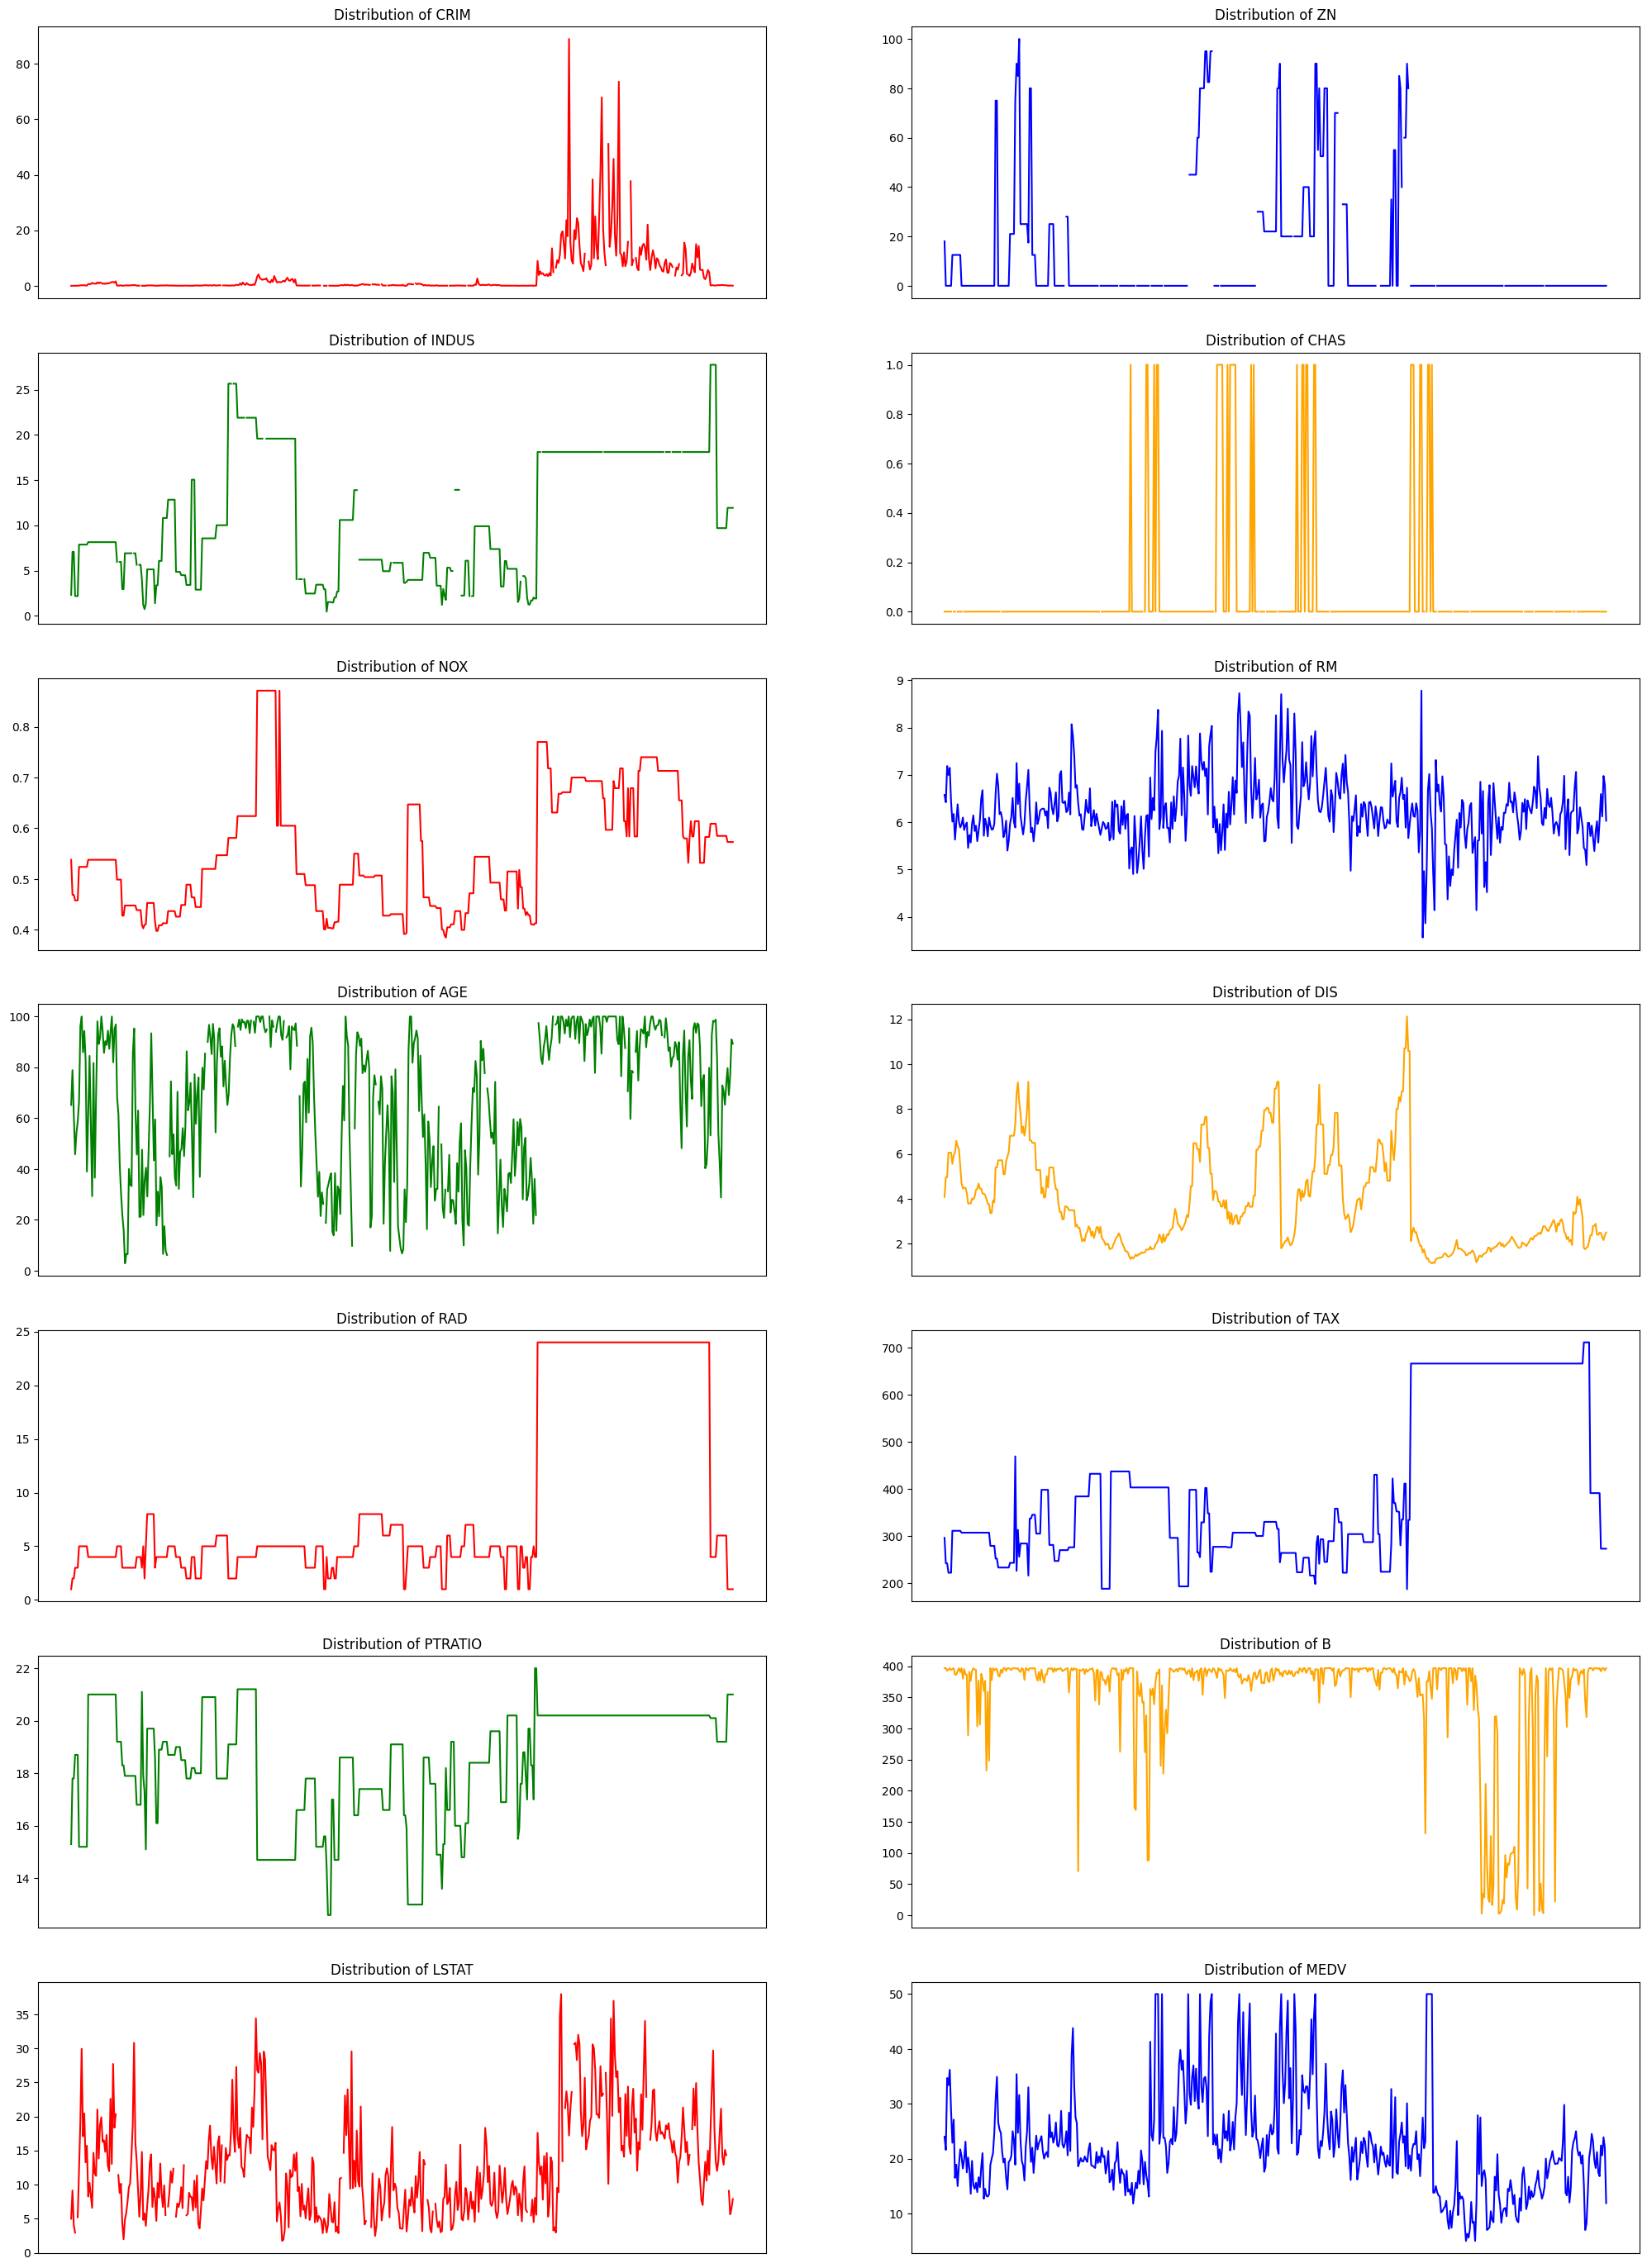

In [4]:
fig, axs = plt.subplots(7, 2, figsize=(25, 35))
colors = np.array(["red", "blue", "green", "orange"])

for i, attribute in enumerate(housing_attributes):
    label_data = housing_df[attribute]
    subplot = axs[int(i / 2), i % 2]
    subplot.plot(range(len(label_data)), label_data, color=colors[i % 4])
    subplot.set_title(f"Distribution of {attribute}")
    subplot.set_xticklabels([])
    subplot.set_xticks([])

plt.show()

## Task 3.1.3 - Train-Val-Test split

In [5]:
np.random.seed(0)

housing_df_X, housing_df_Y = housing_df_values[:, :-1], housing_df_values[:, -1]

housing_train_X, housing_val_test_X, housing_train_Y, housing_val_test_Y = train_test_split(housing_df_X, housing_df_Y)
housing_val_X,   housing_test_X,     housing_val_Y,   housing_test_Y     = train_test_split(housing_val_test_X, housing_val_test_Y, train_size=0.6)

## Task 3.1.4 - Data normalization, standardization, irregular data handling

In [6]:
# Replacing missing values with mean of the respective columns/features
housing_train_X = SimpleImputer().fit_transform(housing_train_X)
housing_val_X   = SimpleImputer().fit_transform(housing_val_X)
housing_test_X  = SimpleImputer().fit_transform(housing_test_X)

# Dataset normalization
housing_train_X = normalize(housing_train_X)
housing_val_X   = normalize(housing_val_X)
housing_test_X  = normalize(housing_test_X)

# Dataset standardization
housing_train_X = StandardScaler().fit_transform(housing_train_X)
housing_val_X   = StandardScaler().fit_transform(housing_val_X)
housing_test_X  = StandardScaler().fit_transform(housing_test_X)

## Task 3.2 - MLP Regression Implementation from Scratch

## Task 3.2.1 - MLP class with customizable learning rate, activation function, optimiser, number of hidden layers and neurons

In [7]:
class MLP_Reg():
    def __init__(self, lr=0.001, epochs=1000, activation='sigmoid', optimiser='SGD', num_batches=10, num_layers=5, num_neurons=np.array([15, 18, 10, 8, 5]), loss_function='MSE', progress=True):
        self.lr              = lr
        self.epochs          = epochs
        self.activation      = activation
        self.optimiser       = optimiser
        self.num_batches     = num_batches
        self.num_layers      = num_layers
        self.num_neurons     = num_neurons
        self.weights         = []
        self.biases          = []
        self.inner_outputs   = []
        self.loss_function   = loss_function
        self.progress        = progress

    def __init_weights_biases(self, num_features, rand=True):
        if rand is True:
            self.weights.append(np.random.randn(num_features, self.num_neurons[0]))
            self.biases.append( np.random.randn(1, self.num_neurons[0]))

            for i in range(self.num_layers - 1):
                self.weights.append(np.random.randn(self.num_neurons[i], self.num_neurons[i + 1]))
                self.biases.append( np.random.randn(1, self.num_neurons[i + 1]))

            self.weights.append(np.random.randn(self.num_neurons[-1], 1))
            self.biases.append( np.random.randn(1, 1))

        else:
            self.weights.append(np.zeros((num_features, self.num_neurons[0])))
            self.biases.append( np.zeros((1, self.num_neurons[0])))

            for i in range(self.num_layers - 1):
                self.weights.append(np.zeros((self.num_neurons[i], self.num_neurons[i + 1])))
                self.biases.append( np.zeros((1, self.num_neurons[i + 1])))

            self.weights.append(np.zeros((self.num_neurons[-1], 1)))
            self.biases.append( np.zeros((1, 1)))

    def __init_inner_outputs(self, num_samples):
        for i in range(self.num_layers):
            self.inner_outputs.append(np.zeros((num_samples, self.num_neurons[i])))
        self.inner_outputs.append(np.zeros((num_samples, 1)))

    # Activation functions
    def __sigmoid(self, X):
        X_trunc = X - np.max(X, axis=1)[:, None]
        return np.exp(X_trunc) / np.sum(np.exp(X_trunc), axis=1)[:, None]
    
    def __tanh(self, X):
        return np.tanh(X)
    
    def __relu(self, X):
        return (np.maximum(0, X) % 1e9) + 1e-8

    def __activation(self, X, activation_type=None):
        activation_type = activation_type or self.activation

        if activation_type == 'sigmoid':
            return self.__sigmoid(X)
        elif activation_type == 'tanh':
            return self.__tanh(X)
        elif activation_type == 'relu':
            return self.__relu(X)
    
    # Derivatives of activation functions to be used in backpropagation
    def __sigmoid_derivative(self, X):
        return X * (1 - X)
    
    def __tanh_derivative(self, X):
        return 1 - np.square(X)
    
    def __relu_derivative(self, X):
        return np.where(X > 0, 1, 0)

    def __activation_derivative(self, X, activation_type=None):
        activation_type = activation_type or self.activation
        
        if activation_type == 'sigmoid':
            return self.__sigmoid_derivative(X)
        elif activation_type == 'tanh':
            return self.__tanh_derivative(X)
        elif activation_type == 'relu':
            return self.__relu_derivative(X)

    def __forward_prop(self, X):
        self.inner_outputs[0] = self.__activation(X @ self.weights[0] + self.biases[0])

        for i in range(1, self.num_layers + 1):
            activation_type = 'relu' if i == self.num_layers else self.activation
            self.inner_outputs[i] = self.__activation(self.inner_outputs[i - 1] @ self.weights[i] + self.biases[i], activation_type=activation_type)

    def __SGD(self, X, y):
        for j in range(X.shape[0]):
            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                if i == self.num_layers:
                    dA = (self.__activation_derivative(self.inner_outputs[i][j], activation_type) * (self.inner_outputs[i][j] - y[j]))[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = X[j][:, None] @ dA
                    dB = dA

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __batch_descent(self, X, y):
        for i in range(self.num_layers, -1, -1):
            activation_type = 'relu' if i == self.num_layers else self.activation

            if i == self.num_layers:
                dA = (self.__activation_derivative(self.inner_outputs[i], activation_type) * (self.inner_outputs[i] - y))
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            elif i == 0:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = X.T @ dA
                dB = np.sum(dA, axis=0)

            else:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            self.weights[i] -= self.lr * dW
            self.biases[i]  -= self.lr * dB

    def __mini_batch_descent(self, X, y):
        for batch_num in range(self.num_batches):
            X_batch = X[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
            y_batch = y[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                inner_output = self.inner_outputs[i][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

                if i == self.num_layers:
                    dA = (self.__activation_derivative(inner_output, activation_type) * (inner_output - y_batch))

                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)
                    dW = X_batch.T @ dA
                    dB = np.sum(dA, axis=0)

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)

                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __back_prop(self, X, y):
        if self.optimiser == 'SGD':
            self.__SGD(X, y)
        elif self.optimiser == 'Batch':
            self.__batch_descent(X, y)
        elif self.optimiser == 'Mini_Batch':
            self.__mini_batch_descent(X, y)

    def __mse(self, y):
        return np.mean(np.square(y - self.inner_outputs[-1]))

    def __rmse(self, y):
        return np.sqrt(self.__mse(y))

    def __r_squared(self, y):
        return 1 - (self.__mse(y) / np.var(y))

    def __loss_function(self, y, metric=None):
        metric = self.loss_function if metric is None else metric
        if metric == 'MSE':
            return self.__mse(y)
        elif metric == 'RMSE':
            return self.__rmse(y)
        elif metric == 'R_Squared':
            return self.__r_squared(y)

    def train(self, X, y):
        y = np.reshape(y, (-1, 1))

        self.__init_weights_biases(X.shape[1])
        self.__init_inner_outputs( X.shape[1])

        for i in range(self.epochs):
            self.__forward_prop(X)
            self.__back_prop(X, y)

            _, loss = self.predict(X, y)

            if self.progress is True and (i + 1) % 100 == 0:
                print(f"Epoch {i + 1} ----- Loss: {loss}")

    def predict(self, X, y=None, metric=None):
        self.__forward_prop(X)

        if y is None:
            return self.inner_outputs[-1]
        else:
            return self.inner_outputs[-1], self.__loss_function(y, metric=metric)

In [8]:
mlp = MLP_Reg(lr=0.001, epochs=1000, optimiser='Batch', num_layers=5, num_neurons=np.array([15, 18, 10, 8, 5]), loss_function='MSE')
mlp.train(housing_train_X, housing_train_Y)

Epoch 100 ----- Loss: 85.3081904146774
Epoch 200 ----- Loss: 85.30818842164561
Epoch 300 ----- Loss: 85.30818640735642
Epoch 400 ----- Loss: 85.30818437030685
Epoch 500 ----- Loss: 85.30818230893328
Epoch 600 ----- Loss: 85.30818022160716
Epoch 700 ----- Loss: 85.30817810663014
Epoch 800 ----- Loss: 85.30817596222899
Epoch 900 ----- Loss: 85.30817378655019
Epoch 1000 ----- Loss: 85.30817157765392


## Task 3.3.3 - Metrics vs Activation function and Optimiser

In [9]:
sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'minimise', 'name': 'val_loss'},
    'parameters': {
        'activations': {'values': ['sigmoid', 'tanh', 'relu']},
        'optimisers' : {'values': ['SGD', 'Batch', 'Mini_Batch']},
    }
}

opt_act_metrics_df = pd.DataFrame(columns=['activation', 'optimiser', 'train_loss', 'val_loss'])

In [10]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MLP_Regression_Activation_Optimiser'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     activation, optimiser = wandb.config.activations, wandb.config.optimisers

#     print(f"Run {run_num}/9 ----- Activation: {activation} ----- Optimiser: {optimiser}")
#     print()

#     MLP_tuning = MLP_Reg(activation=activation, optimiser=optimiser, progress=False)
#     MLP_tuning.train(housing_train_X, housing_train_Y)

#     _, wine_train_loss = MLP_tuning.predict(housing_train_X, housing_train_Y)
#     _, wine_val_loss   = MLP_tuning.predict(housing_val_X,   housing_val_Y)

#     opt_act_metrics_df.loc[len(opt_act_metrics_df)] = [activation, optimiser, wine_train_loss, wine_val_loss]

#     wandb.log({'activation': activation, 'optimiser': optimiser, 'train_loss': wine_train_loss, 'val_loss': wine_val_loss})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# opt_act_metrics_df.to_csv("./Data/3.3.3.csv")

In [11]:
print("With learning rate of 0.001, 1000 epochs, 5 hidden layers with 15, 18, 0, 8 and 5 neurons")
opt_act_metrics_df = pd.read_csv("./Data/3.3.3.csv")
opt_act_metrics_df = opt_act_metrics_df.drop(columns=["Unnamed: 0"])

val_loss_MSE       = opt_act_metrics_df['val_loss']
val_loss_RMSE      = np.sqrt(val_loss_MSE)
val_loss_R_Squared = 1 - (val_loss_MSE / np.var(housing_val_Y))

opt_act_metrics_df['val_loss_MSE']       = val_loss_MSE
opt_act_metrics_df['val_loss_RMSE']      = val_loss_RMSE
opt_act_metrics_df['val_loss_R_Squared'] = val_loss_R_Squared

opt_act_metrics_df = opt_act_metrics_df.drop(columns=['val_loss'])

display(opt_act_metrics_df)

With learning rate of 0.001, 1000 epochs, 5 hidden layers with 15, 18, 0, 8 and 5 neurons


,activation,optimiser,train_loss,val_loss_MSE,val_loss_RMSE,val_loss_R_Squared
0,sigmoid,SGD,155.127336,197.565378,14.055795,-0.977262
1,sigmoid,Batch,162.160806,170.442277,13.055354,-0.705811
2,sigmoid,Mini_Batch,154.261571,165.638602,12.870066,-0.657735
3,tanh,SGD,415.909905,459.821994,21.443460,-3.601964
4,tanh,Batch,273.782328,293.510798,17.132157,-1.937498
5,tanh,Mini_Batch,204.567992,236.429621,15.376268,-1.366221
6,relu,SGD,596.461873,631.827894,25.136187,-5.323424
7,relu,Batch,596.461873,631.827894,25.136187,-5.323424
8,relu,Mini_Batch,596.461873,631.827894,25.136187,-5.323424


## Task 3.3.4 - Hyperparameter Tuning

In [12]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
epochs         = [1000, 5000, 10000, 50000]
hidden_layers  = [
    (1, [18]),
    (3, [15, 18, 12]),
    (3, [15, 10, 5]),
    (5, [12, 15, 21, 10, 3]),
    (6, [16, 20, 25, 21, 15, 10]),
    (10, [15, 18, 21, 25, 20, 16, 13, 10, 8, 5]),
]

sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'minimise', 'name': 'val_loss'},
    'parameters': {
        'lr': {'values': learning_rates},
        'epochs': {'values': epochs},
        'hidden_layers': {'values': hidden_layers},
    }
}

hyper_param_df = pd.DataFrame(columns=['lr', 'epochs', 'num_layers', 'num_neurons', 'train_loss', 'val_loss'])

In [13]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MLP_Regression_Hyperparameters'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     lr, epochs, num_layers, num_neurons = wandb.config.lr, wandb.config.epochs, wandb.config.hidden_layers[0], np.array(wandb.config.hidden_layers[1])

#     print(f"Run {run_num}/120 ----- Learning Rate: {lr} ----- Epochs: {epochs} ----- Number of Layers: {num_layers} ----- Number of Neurons: {num_neurons}")
#     print()

#     MLP_tuning = MLP_Reg(activation='sigmoid', optimiser='Mini_Batch', lr=lr, epochs=epochs, num_layers=num_layers, num_neurons=num_neurons, progress=False)
#     MLP_tuning.train(housing_train_X, housing_train_Y)

#     _, wine_train_loss = MLP_tuning.predict(housing_train_X, housing_train_Y)
#     _, wine_val_loss   = MLP_tuning.predict(housing_val_X,   housing_val_Y)

#     hyper_param_df.loc[len(hyper_param_df)] = [lr, epochs, num_layers, num_neurons, wine_train_loss, wine_val_loss]

#     wandb.log({'lr': lr, 'epochs': epochs, 'num_layers': num_layers, 'num_neurons': num_neurons, 'train_loss': wine_train_loss, 'val_loss': wine_val_loss})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# hyper_param_df.to_csv("./Data/3.3.4.csv")

In [14]:
hyper_param_df = pd.read_csv("./Data/3.3.4.csv")
hyper_param_df = hyper_param_df.drop(columns=["Unnamed: 0"])

val_loss_MSE       = hyper_param_df['val_loss'].to_numpy()
val_loss_RMSE      = np.sqrt(val_loss_MSE)
val_loss_R_Squared = 1 - (val_loss_MSE / np.var(housing_val_Y))

hyper_param_df['val_loss_MSE']       = val_loss_MSE
hyper_param_df['val_loss_RMSE']      = val_loss_RMSE
hyper_param_df['val_loss_R_Squared'] = val_loss_R_Squared

hyper_param_df = hyper_param_df.drop(columns=['val_loss'])

## Task 3.3.4.1 - Best model hyperparameters
- With `Sigmoid` activation function and `Mini Batch` optimiser with `10` batches

| Learning Rate | Epochs | Num_Layers | Num_Neurons            |
|---------------|--------|------------|------------------------|
| 0.0001        | 1000   | 6          | 16, 20, 25, 21, 15, 10 |

## Task 3.3.4.2 - Metrics vs Hyperparameters

In [15]:
print("With activation function as sigmoid and optimiser as Mini_Batch")
display(hyper_param_df)

With activation function as sigmoid and optimiser as Mini_Batch


,lr,epochs,num_layers,num_neurons,train_loss,val_loss_MSE,val_loss_RMSE,val_loss_R_Squared
0,0.0100,1000,1,[18],7474.073086,7648.192995,87.453948,-75.544204
1,0.0050,1000,1,[18],530.217648,558.570046,23.634087,-4.590249
2,0.0010,1000,1,[18],157.597731,191.296325,13.830991,-0.914521
3,0.0005,1000,1,[18],153.481355,170.874614,13.071902,-0.710137
4,0.0001,1000,1,[18],143.907308,155.848160,12.483916,-0.559751
...,...,...,...,...,...,...,...,...
115,0.0100,50000,10,[15 18 21 25 20 16 13 10 8 5],NaN,NaN,NaN,NaN
116,0.0050,50000,10,[15 18 21 25 20 16 13 10 8 5],NaN,NaN,NaN,NaN
117,0.0010,50000,10,[15 18 21 25 20 16 13 10 8 5],85.313412,100.195741,10.009782,-0.002773
118,0.0005,50000,10,[15 18 21 25 20 16 13 10 8 5],85.313412,100.195740,10.009782,-0.002773


## Task 3.4 - Evaluating Model

## Task 3.4.1 - Metrics of test set on best model

In [16]:
best_MLP = MLP_Reg(activation='sigmoid', optimiser='Mini_Batch', lr=0.0001, epochs=1000, num_layers=6, num_neurons=np.array([16, 20, 25, 2, 15, 10]), progress=False)
best_MLP.train(housing_train_X, housing_train_Y)

_, housing_test_MSE    = best_MLP.predict(housing_test_X, housing_test_Y, metric='MSE')
housing_test_RMSE      = np.sqrt(housing_test_MSE)
housing_test_R_Squared = 1 - (housing_test_MSE / np.var(housing_test_Y))

test_metrics_df = pd.DataFrame(columns=['test_loss_MSE', 'test_loss_RMSE', 'test_loss_R_Squared'])
test_metrics_df.loc[0] = [housing_test_MSE, housing_test_RMSE, housing_test_R_Squared]

print("With activation function as sigmoid and optimiser as Mini_Batch")
print("With learning rate of 0.01, 50000 epochs, 3 hidden layers with 15, 10 and 5 neurons")
display(test_metrics_df.style.hide(axis=0))

With activation function as sigmoid and optimiser as Mini_Batch
With learning rate of 0.01, 50000 epochs, 3 hidden layers with 15, 10 and 5 neurons


test_loss_MSE,test_loss_RMSE,test_loss_R_Squared
54.267452,7.366645,-0.035194
